## Imports & Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from tqdm import tqdm
from textwrap import dedent

In [2]:
%matplotlib inline
plt.style.use("default")
fig_dir = "c:/Users/felix/Desktop/internship_letg/figures"

In [3]:
# parsing log files (incl. basic summary on metrics)
class mod_eval():
    def __init__(self, mod_suite_path):
        self.mod_suite = mod_suite_path
    
    def parse_logs(
        self,
        config_idxs = np.arange(10,13), 
        accuracies = "val", 
        test_accs_idxs = np.arange(2,7)
    ):
        # compile infos across model runs
        res = []
        for path, subdirs, files in os.walk(self.mod_suite):
            for idx, name in enumerate(files):
                if name == "logs.txt":
                    with open(os.path.join(path, name)) as f:
                        # read log file
                        lines = f.readlines()
                        lines = [line.rstrip() for line in lines]
                        # filter for relevant subsections
                        config_idx = lines.index("--------config--------")
                        datainfo_idx = lines.index("--------data info--------")
                        eval_idx = lines.index("--------evaluation--------")
                        process_idx = lines.index("--------training--------")
                        # get hyperparam info
                        if isinstance(config_idxs, str) and config_idxs == "all":
                            config_idxs = np.arange(1, datainfo_idx-config_idx-1)
                        config = [lines[x] for x in [config_idx + x for x in config_idxs]]
                        config = [x.split(":") for x in config]
                        config = pd.DataFrame(config)
                        if accuracies == "val":
                            # get val acc
                            process = lines[process_idx + 2: eval_idx-4]
                            process = [x[10:].split("|") for x in process]
                            get_vals = lambda x : float(x.split(":")[-1]) if isinstance(x,str) else list(map(get_vals,x))
                            process_vals = list(map(get_vals, process))
                            process_vars = [dedent(x.split(":")[0]) for x in process[0]]
                            process = pd.DataFrame(process_vals, columns=process_vars)
                            min_val_idx = process.idxmin()["valid_loss"]
                            val_accs = pd.DataFrame(process.iloc[min_val_idx,2:]).reset_index()
                            val_accs = pd.DataFrame(val_accs[:].values)
                            accs = val_accs
                        elif accuracies == "test":
                            # get test acc
                            test_accs = [lines[x] for x in [eval_idx + x for x in test_accs_idxs]]
                            test_accs = [x.split(":") for x in test_accs]
                            test_accs = pd.DataFrame(test_accs)
                            accs = test_accs
                        # summarise info as df 
                        summary = pd.concat([config, accs], ignore_index=True).reset_index(drop=True)
                        summary = summary.rename(columns = {0: "parameter", 1: "value"})
                        summary.insert(0, "type", [*["config" for x in range(len(config))], *["acc" for x in range(len(accs))]])
                        summary.insert(0, "exp_no", [os.path.split(path)[-1] for x in range(len(summary))])
                        res.append(summary)
        self.res = pd.concat(res)
        # group infos per hyperparam config
        self.res_wide = self.res.pivot(index="exp_no", columns=["type", "parameter"], values="value")
        config_cols = [x for x in self.res_wide.columns if x[0] == "config"]
        for col in config_cols: 
            self.res_wide[col] = self.res_wide[col].str.strip()
        acc_cols = [x for x in self.res_wide.columns if x[0] == "acc"]
        self.res_wide[acc_cols] = self.res_wide[acc_cols].apply(pd.to_numeric)
        self.res_configwise = self.res_wide.groupby([x for x in self.res_wide.columns if x[0] == "config"])

    def show_summary(self, summary_stats="mean", sort_value="MeanAbsoluteError"):
        return eval(f"self.res_configwise.{summary_stats}().sort_values([('acc', '{sort_value}')])")

    def show_detail(self, **kwargs):
        for kwarg in kwargs.items():
            # check
            if not ('config', f'{kwarg[0]}') in self.res_wide.columns:
                raise TypeError(f"Argument {kwarg[0]} not part of hyperparameters.")
            # create filter
            filter_all = []
            for kwarg in kwargs.items():
                filter = self.res_wide[('config', f'{kwarg[0]}')] == kwarg[1]
                if len(filter_all):
                    filter_all = [x and y for x, y in zip(filter_all, filter)]
                else:
                    filter_all = filter
            # return filtered df
            return self.res_wide[filter_all]

    def calc_stats(self, summary_func=["mean", "min"], metric="MeanAbsoluteError"):
        res_summary = []
        mod_metric_I = eval(f"self.res_configwise.{summary_func[0]}[('acc', '{metric}')]")
        mod_metric_I = pd.Series(mod_metric_I, name=f"acc_{summary_func[0].split('(')[0]}")
        mod_metric_II = eval(f"self.res_configwise.{summary_func[1]}[('acc', '{metric}')]")
        mod_metric_II = pd.Series(mod_metric_II, name=f"acc_{summary_func[1].split('(')[0]}")
        res_summary = pd.DataFrame([mod_metric_I, mod_metric_II]).transpose().reset_index()
        res_summary.columns = [x[-1] if isinstance(x,tuple) else x for x in res_summary.columns]
        self.bivar_stats = res_summary

In [4]:
# plotting funcs
def vis_mods_maes(mod_df, metric, metric_label):
    fig = sns.catplot(
        x = "variable",
        y = metric,
        kind = "swarm",
        hue = "variable",
        palette = "viridis",
        data = mod_df,
    )
    sns.boxplot(showmeans=True,
                meanline=True,
                meanprops={'color': 'k', 'ls': '-', 'lw': 2},
                medianprops={'visible': False},
                whiskerprops={'visible': False},
                zorder=10,
                width=0.5,
                x="variable",
                y=metric,
                data=mod_df,
                showfliers=False,
                showbox=False,
                showcaps=False,
                ax=fig.axes[0][0]);
    fig.axes[0][0].set_ylabel(metric_label)
    return fig

## Ia. AE regression - hyperparams part I

In [5]:
mod_path = "c:/Users/felix/Desktop/internship_letg/results/exp_ae_regression"
ae_hyper = mod_eval(mod_path)
ae_hyper.parse_logs(np.arange(10,13))
ae_hyper.show_summary("median", "MeanAbsoluteError")
ae_hyper.calc_stats(summary_func=["quantile(q=0.25)", "median()"])
ae_hyper.bivar_stats.sort_values("acc_median")

,lr,optimiser,loss,acc_quantile,acc_median
0,0.001,Adam,L1,8.161378,8.885625
3,0.001,AdamW,L2,8.408850,9.262930
4,0.01,Adam,L1,8.112535,9.372790
5,0.01,Adam,L2,8.807398,9.764615
1,0.001,Adam,L2,8.196135,9.820950
2,0.001,AdamW,L1,7.904988,10.110725
6,0.01,AdamW,L1,8.015612,10.237000
7,0.01,AdamW,L2,9.142510,12.094985


In [6]:
# show detailed training results for best/chosen hyperparam config
ae_hyper.show_detail(lr = "0.001", optimiser = "Adam", loss = "L1")

type      config                              acc                   \
parameter     lr optimiser loss MeanAbsoluteError MeanSquaredError   
exp_no                                                               
mod_80     0.001      Adam   L1          12.30598        252.29297   
mod_81     0.001      Adam   L1           8.73205        110.50779   
mod_82     0.001      Adam   L1          10.00059        184.86411   
mod_83     0.001      Adam   L1           7.15420         98.30585   
mod_84     0.001      Adam   L1           8.58436         98.06826   
mod_85     0.001      Adam   L1           8.36268        118.55939   
mod_86     0.001      Adam   L1           8.20887         95.15528   
mod_87     0.001      Adam   L1           6.98398         73.16589   
mod_88     0.001      Adam   L1          12.60145        303.09720   
mod_89     0.001      Adam   L1          10.43676        211.78488   
mod_90     0.001      Adam   L1           9.40769        124.58361   
mod_91     0.001      Adam   L1           9.03920        149.01041   
mod_92     0.001      Adam   L1          10.40330        228.42821   
mod_93     0.001      Adam   L1           8.01890        103.87828   
mod_94     0.001      Adam   L1           8.72783        119.89787   
mod_95     0.001      Adam   L1           7.51788         92.30186   
mod_96     0.001      Adam   L1           9.08611        134.22336   
mod_97     0.001      Adam   L1           7.78808         95.34930   
mod_98     0.001      Adam   L1          10.68232        217.55913   
mod_99     0.001      Adam   L1          25.21561        793.08936   

type                                                 
parameter PearsonCorrCoef SpearmanCorrCoef  R2Score  
exp_no                                               
mod_80            0.86058          0.87392  0.73282  
mod_81            0.92645          0.92914  0.85812  
mod_82            0.87372          0.86164  0.76335  
mod_83            0.95111          0.91278  0.90323  
mod_84            0.94812          0.93775  0.89057  
mod_85            0.95079          0.88061  0.89567  
mod_86            0.96905          0.83620  0.91933  
mod_87            0.96509          0.94987  0.92823  
mod_88            0.77041          0.76469  0.59249  
mod_89            0.86308          0.88727  0.73184  
mod_90            0.93228          0.88860  0.86807  
mod_91            0.90207          0.89748  0.80868  
mod_92            0.85317          0.82409  0.70758  
mod_93            0.94818          0.92204  0.89774  
mod_94            0.93178          0.93159  0.86621  
mod_95            0.96796          0.87327  0.91877  
mod_96            0.95379          0.78526  0.88621  
mod_97            0.95396          0.93329  0.90647  
mod_98            0.85486          0.82961  0.70750  
mod_99            0.49704          0.53668 -0.00419

In [7]:
# check correlation of val & test accs for general relevance of hyperparameter tuning
def corr_val_test(mod_path):
    mod_val = mod_eval(mod_path)
    mod_val.parse_logs(np.arange(10,13), "val")
    mod_test = mod_eval(mod_path) 
    mod_test.parse_logs(np.arange(10,13), "test")
    val_test_df = pd.merge(mod_val.res_wide.add_suffix("_val"), mod_test.res_wide.add_suffix("_test"), left_index=True, right_index=True)
    corrs = {}
    for metric in mod_val.res_wide["acc"].columns:
            pears = val_test_df[[('acc_val', f'{metric}_val'), ('acc_test', f'{metric}_test')]].corr()
            spear = val_test_df[[('acc_val', f'{metric}_val'), ('acc_test', f'{metric}_test')]].corr("spearman")
            corrs[metric] = {"pearsons_r": pears.iloc[0,1].round(3), "spearman": spear.iloc[0,1].round(3)}
    return pd.DataFrame(corrs).transpose()

corr_val_test(mod_path)

,pearsons_r,spearman
MeanAbsoluteError,0.843,0.183
MeanSquaredError,0.903,0.238
PearsonCorrCoef,0.197,-0.047
SpearmanCorrCoef,0.269,0.029
R2Score,0.893,0.251


## Ib. AE regression - hyperparams part II

In [8]:
# create comprehensive df for results of all experiments - across splits, trials, var, hyperparams
mod_res = []
mod_paths = "c:/Users/felix/Desktop/internship_letg/results/final_ae_regression"
for path, subdirs, files in tqdm(os.walk(mod_paths)):
    if len(files):
        mod_val = mod_eval(path)
        mod_val.parse_logs("all", accuracies="val")
        mod_res.append(mod_val.res_wide)

mod_res = pd.concat(mod_res)
mod_res.columns = mod_res.columns.get_level_values(1)

765it [00:12, 62.13it/s]


In [9]:
vars = [os.path.split(os.path.dirname(x))[1] for x in mod_res["path_train"]]
splits = [os.path.split(os.path.dirname(os.path.dirname(x)))[1] for x in mod_res["path_train"]]
mod_res.insert(0, "variable", vars)
mod_res.insert(1, "split", splits)
augs = ["augmentation" if x=="True" else "no augmentation" for x in mod_res["augment"]]
drops = ["dropout" if x=="0.2" else "no dropout" for x in mod_res["dropout"]]
mod_res.insert(0, "hyperparams", [f"{x[0]}\n{x[1]}" for x in zip(augs, drops)])

C:\Users\felix\AppData\Local\Temp\ipykernel_31528\3033676561.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)


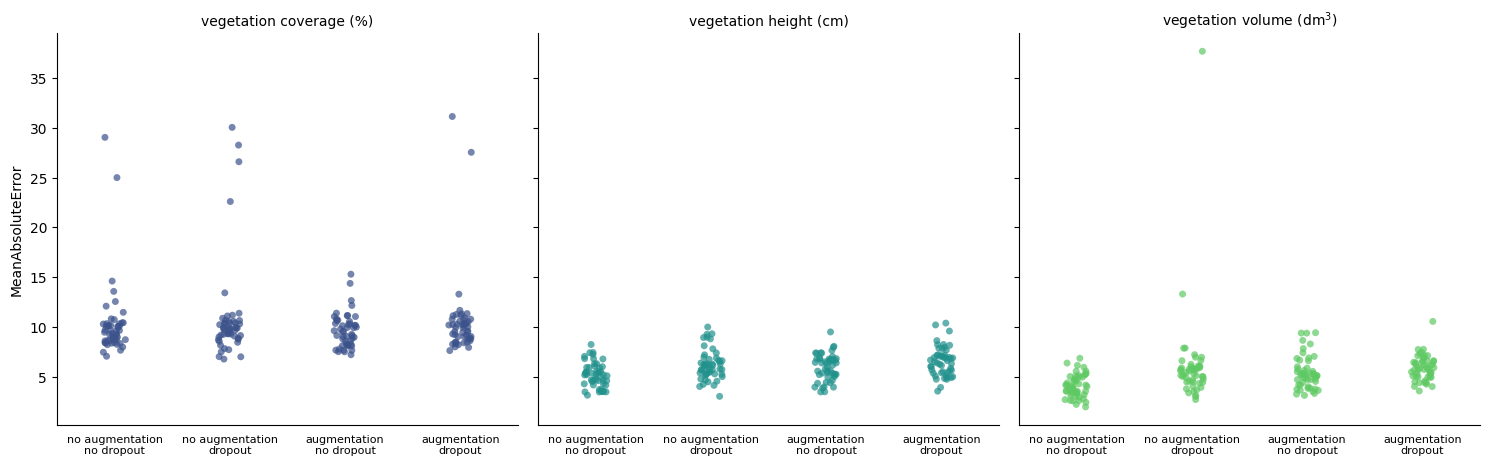

In [10]:
order_hyperp = [
    'no augmentation\nno dropout',
    'no augmentation\ndropout', 
    'augmentation\nno dropout',
    'augmentation\ndropout',
]

fig = sns.catplot(
    x = "hyperparams",
    y = "MeanAbsoluteError",
    kind = "strip",
    hue = "variable",
    col = "variable",
    alpha = 0.7,
    order = order_hyperp,
    palette = "viridis",
    data = mod_res,
)

for ax in fig.axes[0]:
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.tick_params(bottom = False)
    ax.xaxis.label.set_visible(False)

fig.axes[0][0].set_title("vegetation coverage (%)", fontsize=10)
fig.axes[0][1].set_title("vegetation height (cm)", fontsize=10)
fig.axes[0][2].set_title("vegetation volume (dm$^3$)", fontsize=10);

fig.savefig(os.path.join(fig_dir, "eval_ae_hyper.png"), dpi=300)
# tbd: set colors accoding to figures for EDA
# sns.color_palette(["#9ca8c4","#8fc7c5","#aee3b0"])

In [11]:
acc_mean = mod_res.groupby(["variable", "augment", "dropout"]).median()["MeanAbsoluteError"]
acc_q25 = mod_res.groupby(["variable", "augment", "dropout"]).quantile(0.25)["MeanAbsoluteError"]
acc_summary = pd.DataFrame([acc_q25, acc_mean]).transpose()
acc_summary.columns = ["MAE_q25", "MAE_median"]
acc_summary

C:\Users\felix\AppData\Local\Temp\ipykernel_31528\3317681344.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  acc_q25 = mod_res.groupby(["variable", "augment", "dropout"]).quantile(0.25)["MeanAbsoluteError"]


MAE_q25  MAE_median
variable augment dropout                      
coverage False   0.0      8.643830    9.532740
                 0.2      9.020187    9.810840
         True    0.0      8.268577    9.530015
                 0.2      8.840307    9.942205
height   False   0.0      4.339860    5.203835
                 0.2      5.273820    6.121165
         True    0.0      5.192592    6.259115
                 0.2      5.424188    6.569655
volume   False   0.0      3.301423    3.999565
                 0.2      4.509570    5.510925
         True    0.0      4.244790    5.179730
                 0.2      5.000208    5.803820

## Ic. AE regression - final model

In [12]:
# create comprehensive df for results of best hyperparam comb - across splits, trials, var
def parent_dir_n(dir, n):
    for i in range(n):
        dir = os.path.dirname(dir)
    return dir

mod_res = []
mod_paths = "c:/Users/felix/Desktop/internship_letg/results/final_ae_regression/drop_0_aug_False"
for path, subdirs, files in tqdm(os.walk(mod_paths)):
    if len(files):
        mod_path = path
        mod_val = mod_eval(mod_path)
        mod_val.parse_logs(accuracies="val")
        mod_val = mod_val.res_wide.drop("config", axis=1, level=0)
        mod_test = mod_eval(mod_path)
        mod_test.parse_logs(accuracies="test")
        mod_test = mod_test.res_wide.drop("config", axis=1, level=0)
        mod_confs = mod_eval(mod_path)
        mod_confs.parse_logs("all")
        mod_confs = mod_confs.res_wide.drop("acc", axis=1, level=0)
        mod_df = pd.merge(mod_val.add_suffix("_val"), mod_test.add_suffix("_test"), left_index=True, right_index=True)
        mod_df = pd.merge(mod_confs, mod_df, left_index=True, right_index=True)
        mod_res.append(mod_df)

mod_res = pd.concat(mod_res)
mod_res.columns = mod_res.columns.get_level_values(1)
mod_res = mod_res.reset_index()
vars = [os.path.split(os.path.dirname(x))[1] for x in mod_res["path_train"]]
splits = [os.path.split(parent_dir_n(x, 2))[1] for x in mod_res["path_train"]]
mod_res.insert(0, "variable", vars)
mod_res.insert(1, "split", splits)

191it [00:07, 26.00it/s]


In [13]:
# get best models based on MAE val
best_val_idx = mod_res.groupby(["variable", "split"]).idxmin()["MeanAbsoluteError_val"]
ae_mods = mod_res[mod_res.index.isin(best_val_idx)].sort_values(["variable", "split"])
ae_mods.groupby("variable").mean()

C:\Users\felix\AppData\Local\Temp\ipykernel_31528\900181339.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  best_val_idx = mod_res.groupby(["variable", "split"]).idxmin()["MeanAbsoluteError_val"]


parameter,MeanAbsoluteError_val,MeanSquaredError_val,PearsonCorrCoef_val,SpearmanCorrCoef_val,R2Score_val,MeanAbsoluteError_test,MeanSquaredError_test,PearsonCorrCoef_test,SpearmanCorrCoef_test,R2Score_test
variable,,,,,,,,,,
coverage,8.527783,122.114502,0.935129,0.924874,0.867390,9.061378,129.559875,0.935857,0.888340,0.857188
height,4.607341,42.605148,0.759286,0.631542,0.569367,5.450663,66.484621,0.617279,0.522577,0.306354
volume,3.461862,29.122886,0.844578,0.851278,0.694107,3.909872,43.768462,0.719468,0.819929,0.498041


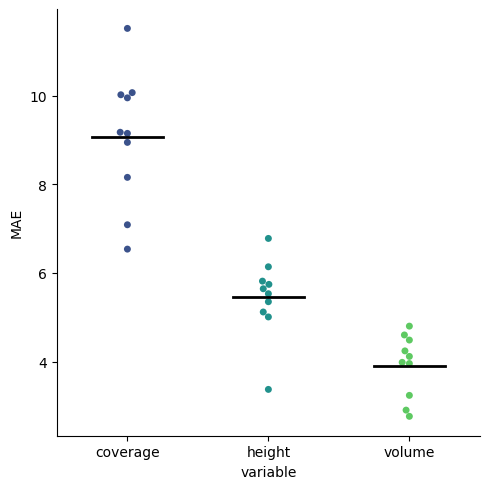

In [14]:
fig = vis_mods_maes(ae_mods, "MeanAbsoluteError_test", "MAE");
fig.savefig(os.path.join(fig_dir, "eval_ae.png"), dpi=300)

## IIa. TSNE regresssion - hyperparams

In [16]:
mod_path = "c:/Users/felix/Desktop/internship_letg/results/exp_tsne_regression"
corr_val_test(mod_path)

# correlation very weak
# hyperparameter tuning effectively worthless
# except for learning rate no significant improvement for any parameter visible anyway
# go for computationally least expensive method -> resnet

,pearsons_r,spearman
MeanAbsoluteError,0.180,0.126
MeanSquaredError,0.268,-0.049
PearsonCorrCoef,0.424,0.120
SpearmanCorrCoef,0.144,0.015
R2Score,0.405,0.133


In [16]:
tsne_hyper = mod_eval(mod_path)
tsne_hyper.parse_logs([7, *np.arange(10,13)])
tsne_hyper.show_summary("median", "MeanAbsoluteError")
tsne_hyper.calc_stats(summary_func=["quantile(q=0.25)", "median()"])
tsne_hyper.bivar_stats.sort_values("acc_median")

,net,lr,optimiser,loss,acc_quantile,acc_median
2,efficientnet,0.001,AdamW,L1,5.32269,5.89006
6,efficientnet,0.01,AdamW,L1,5.93663,6.21568
10,resnet,0.001,AdamW,L1,6.04434,6.30646
1,efficientnet,0.001,Adam,L2,6.18836,6.40918
3,efficientnet,0.001,AdamW,L2,6.21869,6.52648
9,resnet,0.001,Adam,L2,6.46505,6.55984
4,efficientnet,0.01,Adam,L1,6.15213,6.59502
5,efficientnet,0.01,Adam,L2,5.96569,6.65703
0,efficientnet,0.001,Adam,L1,5.19950,6.65854
11,resnet,0.001,AdamW,L2,6.41698,6.73250


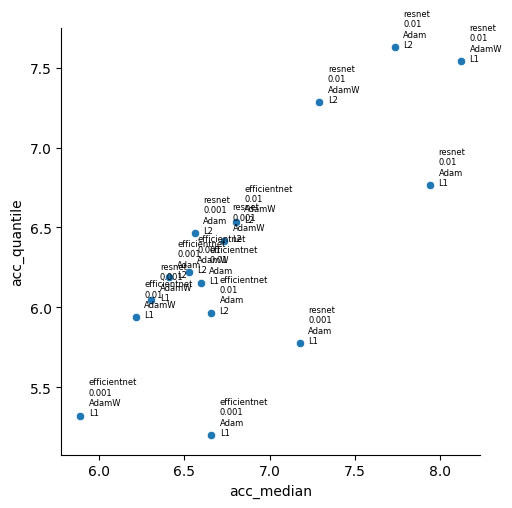

In [17]:
# plot summary - model configuration & accuracy
fig = sns.relplot(x = "acc_median", y = "acc_quantile", data = tsne_hyper.bivar_stats)
ax = fig.axes[0,0]
for idx,row in tsne_hyper.bivar_stats.iterrows():
    x = row["acc_median"]
    y = row["acc_quantile"]
    info = f"{row[0]}\n{row[1]}\n{row[2]}\n{row[3]}"
    ax.text(x+.05, y, info, size=6, horizontalalignment='left')

## IIb. TSNE regression - final model

In [17]:
# create comprehensive df for results of best hyperparam comb - across splits, trials, var
def parent_dir_n(dir, n):
    for i in range(n):
        dir = os.path.dirname(dir)
    return dir

mod_res = []
mod_paths = "c:/Users/felix/Desktop/internship_letg/results/final_tsne_regression"
for path, subdirs, files in tqdm(os.walk(mod_paths)):
    if len(files):
        mod_path = path
        mod_val = mod_eval(mod_path)
        mod_val.parse_logs(accuracies="val")
        mod_val = mod_val.res_wide.drop("config", axis=1, level=0)
        mod_test = mod_eval(mod_path)
        mod_test.parse_logs(accuracies="test")
        mod_test = mod_test.res_wide.drop("config", axis=1, level=0)
        mod_confs = mod_eval(mod_path)
        mod_confs.parse_logs("all")
        mod_confs = mod_confs.res_wide.drop("acc", axis=1, level=0)
        mod_df = pd.merge(mod_val.add_suffix("_val"), mod_test.add_suffix("_test"), left_index=True, right_index=True)
        mod_df = pd.merge(mod_confs, mod_df, left_index=True, right_index=True)
        mod_res.append(mod_df)

mod_res = pd.concat(mod_res)
mod_res.columns = mod_res.columns.get_level_values(1)
mod_res = mod_res.reset_index()
vars = [os.path.split(os.path.dirname(x))[1] for x in mod_res["path_train"]]
splits = [os.path.split(parent_dir_n(x, 3))[1] for x in mod_res["path_train"]]
mod_res.insert(0, "variable", vars)
mod_res.insert(1, "split", splits)

341it [00:13, 24.88it/s]


In [18]:
# get best models based on MAE val
best_val_idx = mod_res.groupby(["variable", "split"]).idxmin()["MeanAbsoluteError_val"]
tsne_mods = mod_res[mod_res.index.isin(best_val_idx)].sort_values(["variable", "split"])
tsne_mods.groupby("variable").mean()

C:\Users\felix\AppData\Local\Temp\ipykernel_31528\2176570065.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  best_val_idx = mod_res.groupby(["variable", "split"]).idxmin()["MeanAbsoluteError_val"]


parameter,MeanAbsoluteError_val,MeanSquaredError_val,PearsonCorrCoef_val,SpearmanCorrCoef_val,R2Score_val,MeanAbsoluteError_test,MeanSquaredError_test,PearsonCorrCoef_test,SpearmanCorrCoef_test,R2Score_test
variable,,,,,,,,,,
coverage,6.337382,80.192557,0.959529,0.943537,0.911051,7.338115,92.938677,0.953678,0.901041,0.896601
height,3.263967,23.444557,0.885649,0.771293,0.760320,4.565167,48.230366,0.747176,0.695457,0.511632
volume,2.433341,17.312662,0.917129,0.887320,0.813446,3.446714,35.980508,0.826313,0.863920,0.603782


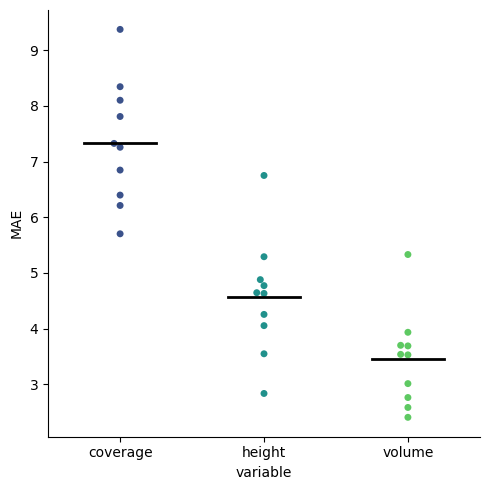

In [20]:
# visualise best models
fig = vis_mods_maes(tsne_mods, "MeanAbsoluteError_test", "MAE");
fig.savefig(os.path.join(fig_dir, "eval_tsne.png"), dpi=300)

## III. RF regression

In [21]:
# read results for rf regression mods
rf_mods = pd.read_csv("c:/Users/felix/Desktop/internship_letg/results/final_rf_regression/test_accs_all.csv")
rf_mods = rf_mods.pivot(columns="index", index=["variable", "split"]).stack(0).reset_index()
rf_mods.groupby("variable").mean()

index,MeanAbsoluteError,MeanSquaredError,PearsonCorrCoef,R2Score,SpearmanCorrCoef
variable,,,,,
coverage,8.303041,118.698830,0.935720,0.867711,0.908680
height,5.609625,64.596761,0.624629,0.347868,0.570013
volume,3.922294,44.921973,0.726714,0.510634,0.813218


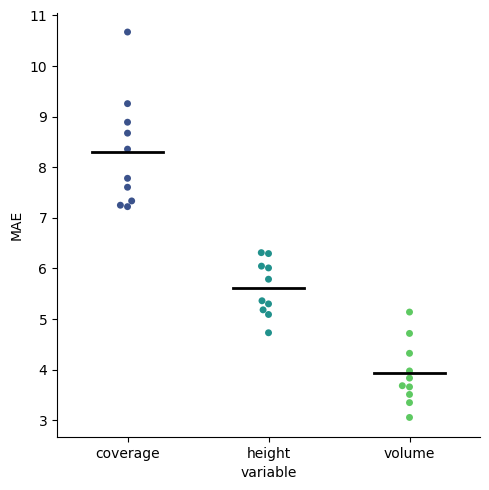

In [22]:
# visualise best models
fig = vis_mods_maes(rf_mods, "MeanAbsoluteError", "MAE");
fig.savefig(os.path.join(fig_dir, "eval_rf.png"), dpi=300)

## IV. Summary - All models

In [23]:
# create comprehensive df encompassing all models 
ae_mods.columns = [col.split("_")[0] for col in ae_mods.columns]
ae_mods = ae_mods.iloc[:,[0,1,23,24,25,26,27]]
ae_mods["mod_type"] = "model B"
tsne_mods.columns = [col.split("_")[0] for col in tsne_mods.columns]
tsne_mods = tsne_mods.iloc[:,[0,1,20,21,22,23,24]]
tsne_mods["mod_type"] = "model C"
rf_mods = rf_mods.drop(columns="level_2")
rf_mods["mod_type"] = "model A"

In [24]:
all_mods = pd.concat([rf_mods, ae_mods, tsne_mods])
all_mods = all_mods.melt(
    id_vars=["variable", "split", "mod_type"], 
    value_vars=["MeanAbsoluteError", "MeanSquaredError", "PearsonCorrCoef", "R2Score", "SpearmanCorrCoef"],
    var_name="metric"
)
all_mods

,variable,split,mod_type,metric,value
0,coverage,split_1,model A,MeanAbsoluteError,7.220000
1,coverage,split_10,model A,MeanAbsoluteError,8.356667
2,coverage,split_2,model A,MeanAbsoluteError,10.671250
3,coverage,split_3,model A,MeanAbsoluteError,7.248333
4,coverage,split_4,model A,MeanAbsoluteError,9.255834
...,...,...,...,...,...
445,volume,split_5,model C,SpearmanCorrCoef,0.874290
446,volume,split_6,model C,SpearmanCorrCoef,0.848130
447,volume,split_7,model C,SpearmanCorrCoef,0.827170
448,volume,split_8,model C,SpearmanCorrCoef,0.878210


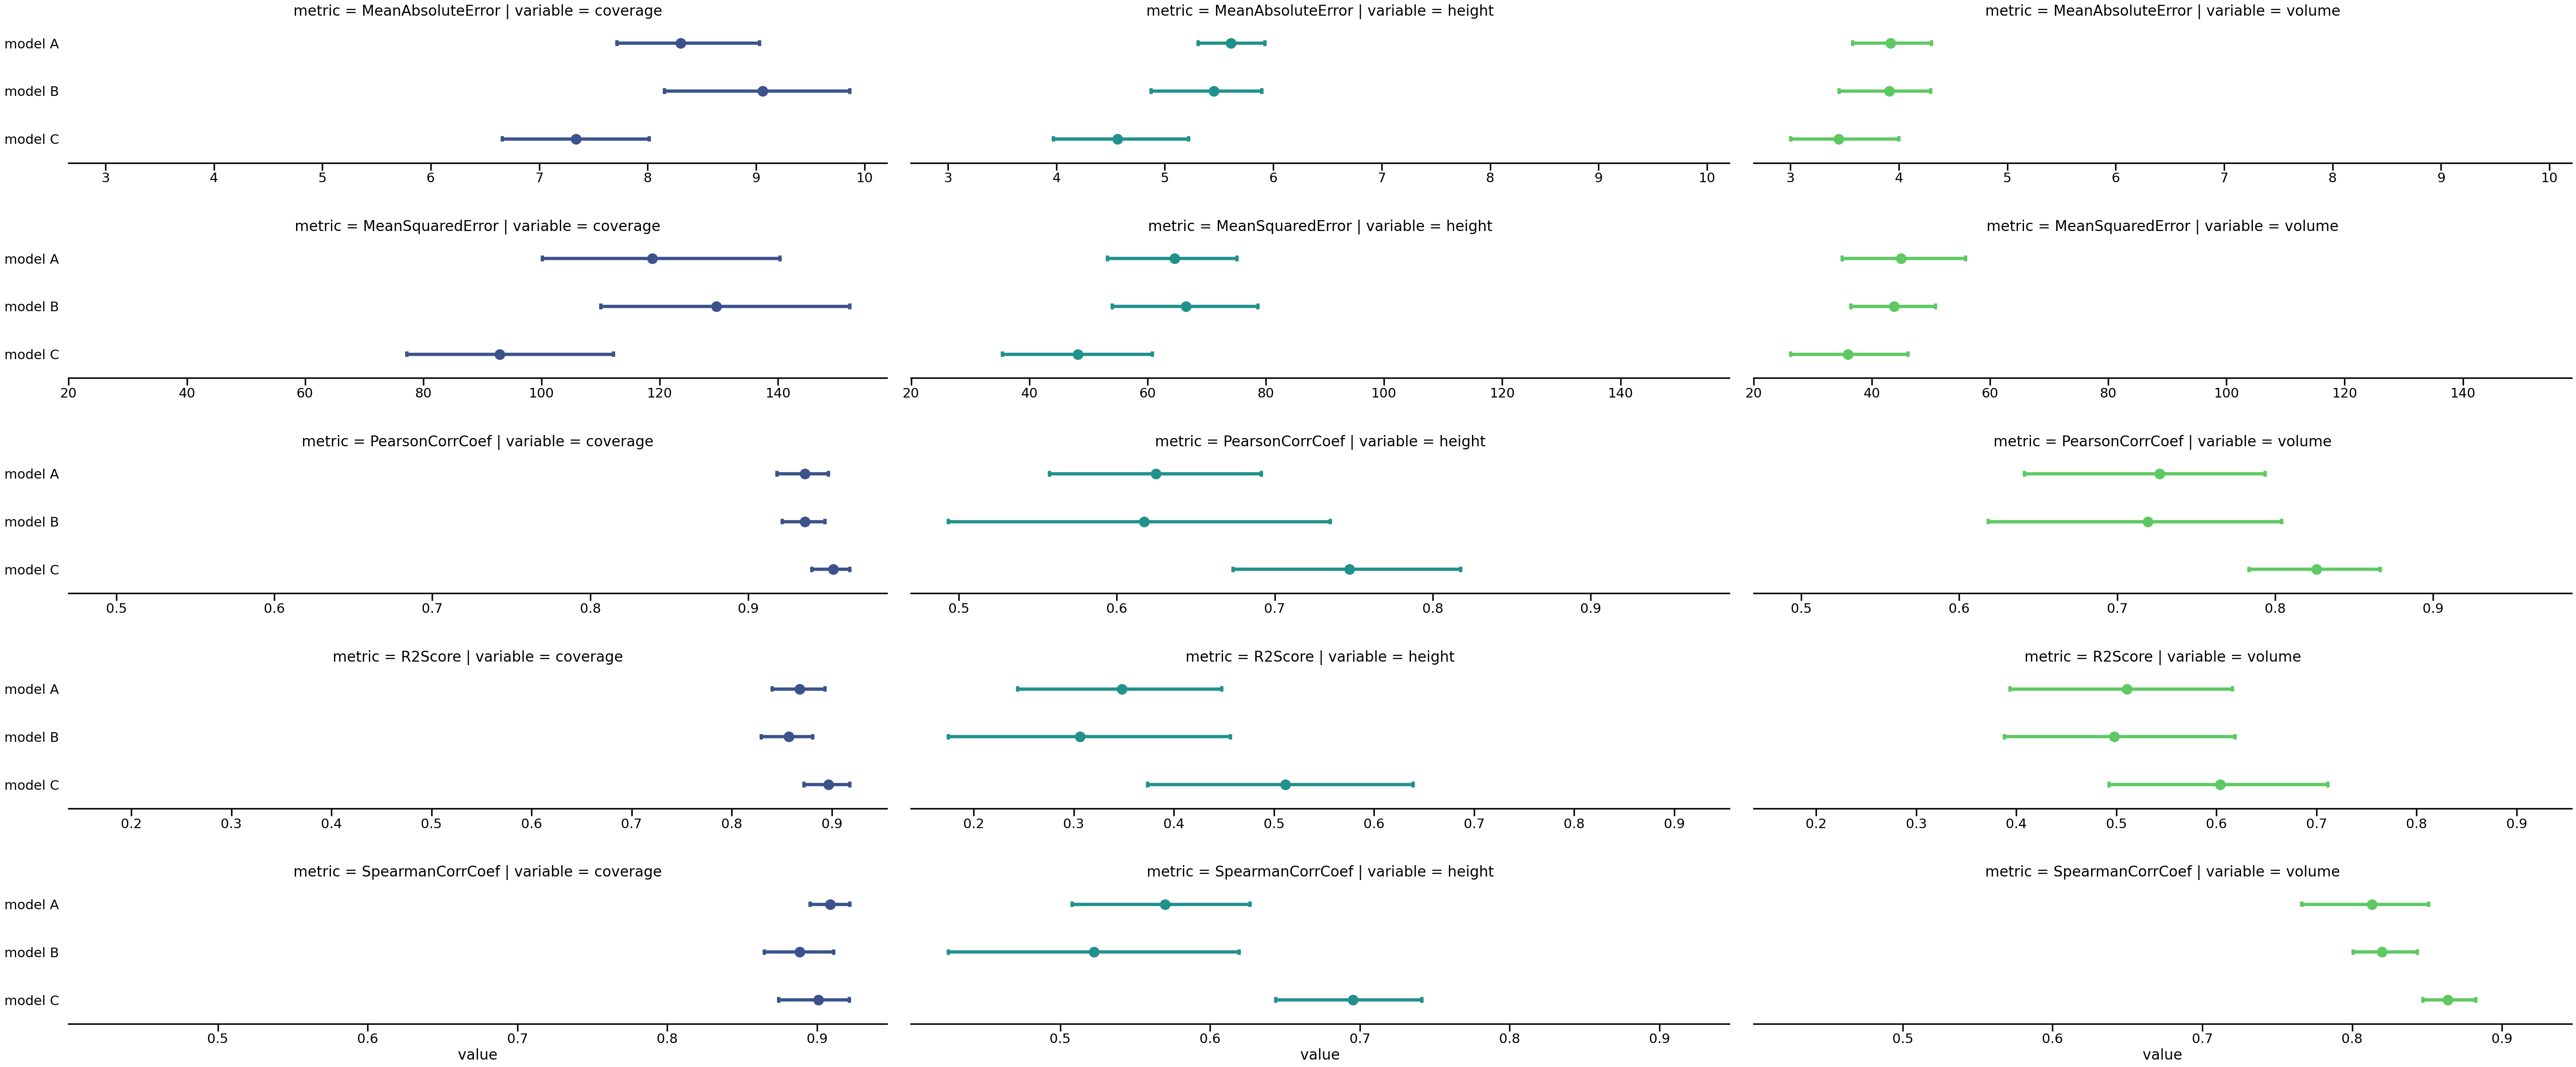

In [27]:
# plot direct comparison to evaluate (significant) differences
sns.set_context("poster")
fig = sns.catplot(
    x = "value",
    y = "mod_type",
    row = "metric",
    col = "variable",
    hue = "variable",
    linestyles = "mod_type",
    kind = "point",
    errorbar = ("ci", 95),
    palette = "viridis",
    capsize = 0.05, 
    join = False,
    sharex = "row",
    data = all_mods,
    aspect = 4
);
for ax in fig.axes:
    ax[0].set_ylabel("")
    for axs in ax:
        axs.tick_params(left=False)

fig.despine(left=True)
plt.subplots_adjust(hspace = 0.5);

fig.savefig(os.path.join(fig_dir, "eval_all.png"), dpi=300)

## Tbd: Ensemble model

In [26]:
# get best models & create ensemble out of them
mod_path = "c:/Users/felix/Desktop/internship_letg/results/final_ae_regression/drop_0_aug_False/split_10/coverage"
ae_hyper = mod_eval(mod_path)
ae_hyper.parse_logs("all")
mods_sorted = ae_hyper.res_wide.sort_values([("acc", "MeanAbsoluteError")])
top_mods = mods_sorted.head(int(np.ceil(len(mods_sorted)/2)))
top_mods.index
mods_sorted

def get_ae_reg_net(mod_run_path):
    # import net file
    sys.path.append("C:/Users/felix/Desktop/internship_letg/scripts/ae_regression_net.py")
    import ae_regression_net as aer
    # copy/parse args from model run
    ae_hyper = mod_eval(mod_run_path)
    ae_hyper.parse_logs("all")
    conf_settings = ae_hyper.res[ae_hyper.res["type"] == "config"]
    for key,val in aer.config.items():
        dtype = str(type(val)).split("'")[1]
        mod_conf = conf_settings[conf_settings["parameter"] == key]["value"]
        mod_conf = dedent(mod_conf.values[0])
        if dtype == "bool":
            if mod_conf == "True":
                mod_conf = True
            else:
                mod_conf = False
        elif dtype in ["int", "float"]:
            mod_conf = eval(f"{dtype}({mod_conf})")
        aer.config[key] = mod_conf
    # define net
    cnn = aer.regression_model(**aer.config)
    cnn.dataloading() 
    cnn.def_net()
    # load trained weights
    path_weights = os.path.join(mod_run_path, "model_params.pt")
    cnn.load_state_dict(torch.load(path_weigths))

test = "c:/Users/felix/Desktop/internship_letg/results/final_ae_regression/drop_0_aug_False/split_7/coverage/mod_0"
get_ae_reg_net(test)

# functions to combine model predictions into one (ensemble)
import itertools
import warnings

def apply_model(model, set="test"):
    metric_collection = metrics.MetricCollection([
        metrics.MeanAbsoluteError(),
        metrics.MeanSquaredError(),
        metrics.PearsonCorrCoef(),
        metrics.SpearmanCorrCoef(),
        metrics.R2Score()
    ])
    accuracy = metric_collection.to(torch.device("cuda", 0))
    model.eval()
    with torch.no_grad():
        for data,labels_idxs in eval(f"dl_{set}"):
            data = data.to(config["device"], dtype=torch.float)
            labels = [float(eval(f"ds_{set}.classes[{x}]")) for x in labels_idxs]
            labels = torch.Tensor(labels).to(config["device"], dtype=torch.float)
            output = model(data)
            accuracy.update(output.view(-1), labels)
    total_accuracy = accuracy.compute()
    accuracy.reset()
    return  total_accuracy, output, labels

def ensemble_prediction(model_idxs, set):
    all_mods = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i in model_idxs:
            model_v = torch.load(os.path.join(save_dir, f"model_{i}"))
            _, o, l = apply_model(model_v, set=set)
            res = pd.DataFrame(np.vstack((l.cpu().numpy(), o.cpu().numpy().flatten()))).transpose().round()
            res = res.rename(columns={0: "measured", 1: "predicted"})
            res["model"] = [f"model_{i}" for x in range(len(res))]
            res = res.reset_index()
            all_mods.append(res)
    mean_pred = pd.concat(all_mods).groupby("index").mean().round(3).sort_values("measured")
    return mean_pred

def eval_ensemble_pred(ensemble_pred):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        eval_dict = {}
        metric_collection = metrics.MetricCollection([
            metrics.MeanAbsoluteError(),
            metrics.MeanSquaredError(),
            metrics.PearsonCorrCoef(),
            metrics.SpearmanCorrCoef(),
            metrics.R2Score()
        ])
        accuracy = metric_collection
        accuracy.update(
            torch.tensor(ensemble_pred["predicted"]), 
            torch.tensor(ensemble_pred["measured"])
        )
        acc = accuracy.compute()
        accuracy.reset()
        return acc

pd.Series(eval_ensemble_pred(ensemble_prediction(np.arange(10,19), "test")))

c:\Users\felix\.virtualenvs\biomass_cnn\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/home/krober_f/biomass_pyrenees/data/point_tiles/splits/split_7/coverage/train'